### Preamble

In [1]:
!pip install -q git+https://github.com/spinsphotonics/hyperwave-community.git

In [2]:
import hyperwave_community as hwc
api_key = "YOUR-API-KEY-HERE"   # Get your API key from your dashboard at: https://spinsphotonics.com/dashboard

# Prevent Colab from over-allocating GPU memory to JAX
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
!pip install -q gdsfactory
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

# Activate the generic PDK (required for newer gdsfactory versions)
gf.CONF.pdk = "generic"

### Device Setup

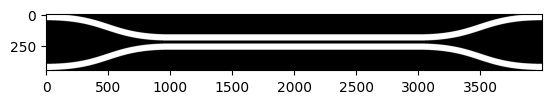

In [4]:
#@title Define Theta

#Import Theta from GDSFactory Component

gfcoupler = gf.components.coupler(
    gap=0.236,
    length=20,
    dy=4,
    dx=10,
    cross_section='strip',
    allow_min_radius_violation=False,
    bend='bend_s').copy()

n_Si = 3.48                            # refractive index of silicon.
n_SiO2 = 1.45                          # refractive index of silica.
target_wavelength = 1.55               # wavelength in microns
resolution = 0.02                      # microns per voxel

theta_coupler, device_info = hwc.component_to_theta(
    component=gfcoupler,
    resolution=resolution
)

# Visualize theta pattern
plt.imshow(theta_coupler, cmap='gray')

Text(0.5, 1.0, 'd_cladding')

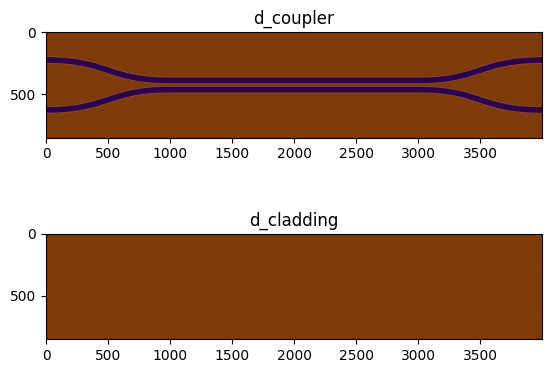

In [5]:
#@title Define Densities

# Define the density patterns of each layer
padding = (0, 0, 200, 200)  # 200px top, 200px bottom to allow room for absorbers

d_coupler = hwc.density(
    theta=theta_coupler,
    pad_width=padding,
    radius=2
)

d_cladding = hwc.density(
    theta=jnp.zeros_like(theta_coupler),
    pad_width=padding,
    radius=2
)

# Create a figure with one row and two columns of subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

im1 = ax1.imshow(d_coupler, cmap='PuOr')
ax1.set_title('d_coupler')

im2 = ax2.imshow(d_cladding, cmap='PuOr')
ax2.set_title('d_cladding')

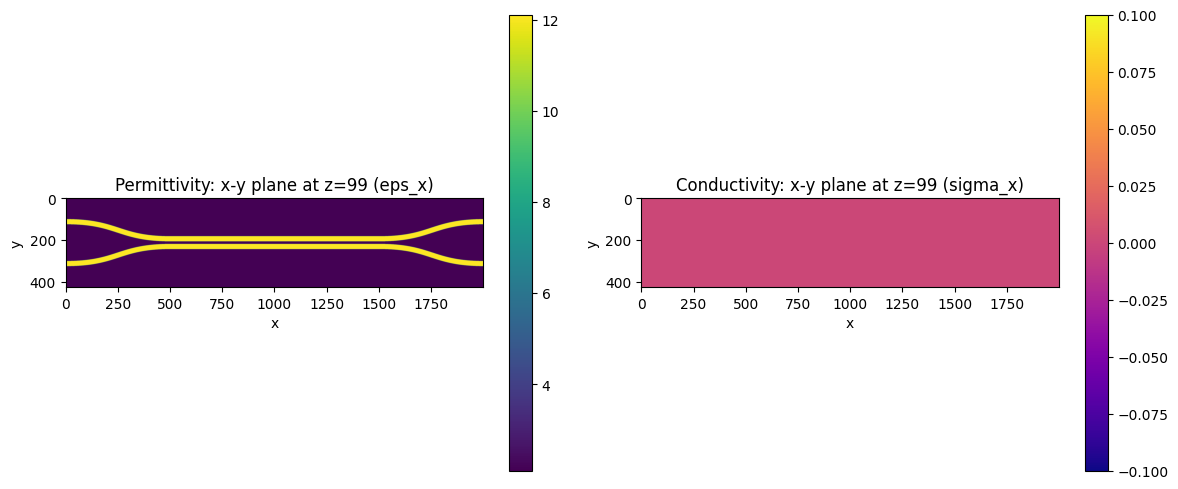

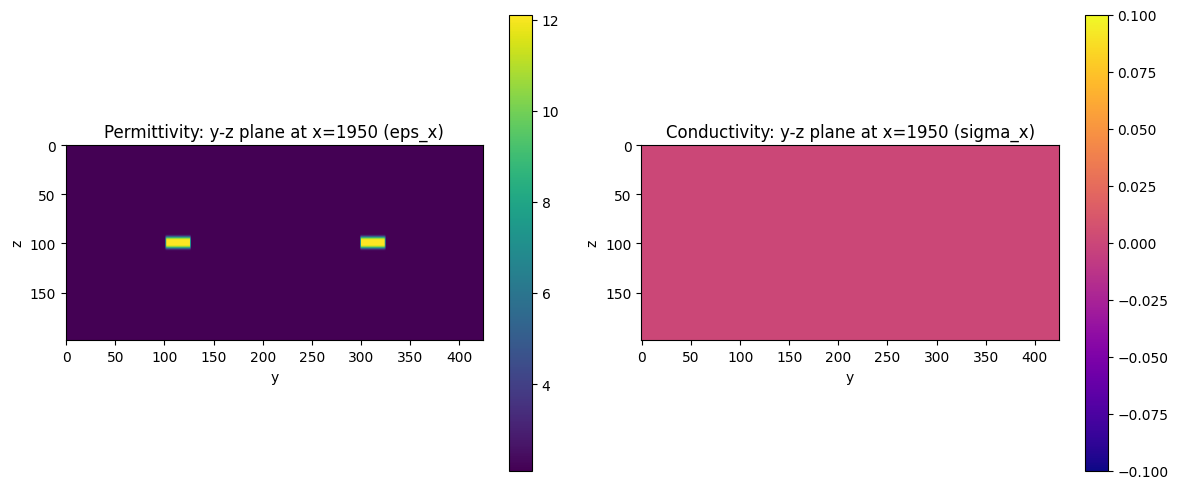

In [6]:
#@title Define Structure

wg_height_um = 0.22  # height of the waveguide along z
coupler_thickness_cells = int(np.round(wg_height_um / resolution))
coupler_thickness_cells = max(1, coupler_thickness_cells)

slab_thickness_um = (4.0 - wg_height_um)/2  # Changed to match the simulation domain
slab_thickness_cells = int(np.round(slab_thickness_um / resolution))

coupler = hwc.Layer(
       density_pattern=d_coupler,
       permittivity_values=(n_SiO2**2, n_Si**2),
       layer_thickness=coupler_thickness_cells
    )

SiO2_slab = hwc.Layer(
       density_pattern=d_cladding,
       permittivity_values=n_SiO2**2,
       layer_thickness=slab_thickness_cells
    )

# Setting up the structure.
user_structure = hwc.create_structure(
    layers=[SiO2_slab, coupler, SiO2_slab],
    vertical_radius=3,
)

user_structure.view(
    show_permittivity=True,
    show_conductivity=True,
    axis="z",
    position=slab_thickness_cells + coupler_thickness_cells // 2,
    cmap_permittivity="viridis"
)

user_structure.view(
    show_permittivity=True,
    show_conductivity=True,
    axis="x",
    position=user_structure.permittivity.shape[1] - 50,
    cmap_permittivity="viridis"
)

In [7]:
user_structure.list_layers()

Layer Stack Description:

Layer 0:
  Density shape: 4000 × 850
  Density range: [0.000, 0.000] (mean: 0.000)
  Pattern type: zeros (empty)
  Permittivity: 2.10 (uniform)
  Thickness: 94 pixels

Layer 1:
  Density shape: 4000 × 850
  Density range: [0.000, 1.000] (mean: 0.119)
  Pattern type: binary pattern
  Permittivity: 2.10 → 12.11 (interpolated)
  Thickness: 11 pixels

Layer 2:
  Density shape: 4000 × 850
  Density range: [0.000, 0.000] (mean: 0.000)
  Pattern type: zeros (empty)
  Permittivity: 2.10 (uniform)
  Thickness: 94 pixels

Total thickness: 199 pixels
Lateral size: 2000 × 425 pixels


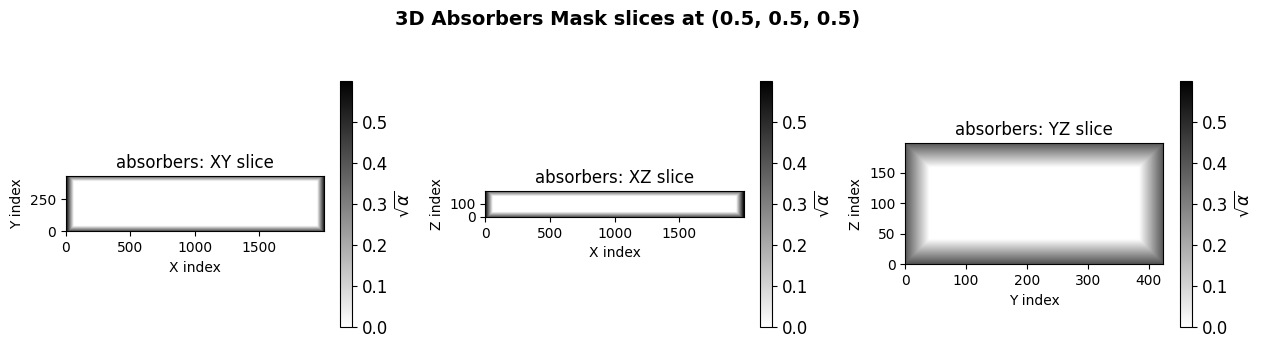

In [8]:
#@title Define Absorber
abs_shape = (60, 40, 40)  # Inward extension of absorbers in (x, y, z)
abs_coeff = 1e-4
_, Lx, Ly, Lz = user_structure.permittivity.shape

absorber = hwc.create_absorption_mask(
    grid_shape=(Lx, Ly, Lz),
    absorption_widths=abs_shape,
    absorption_coeff = abs_coeff,
    show_plots=True
)

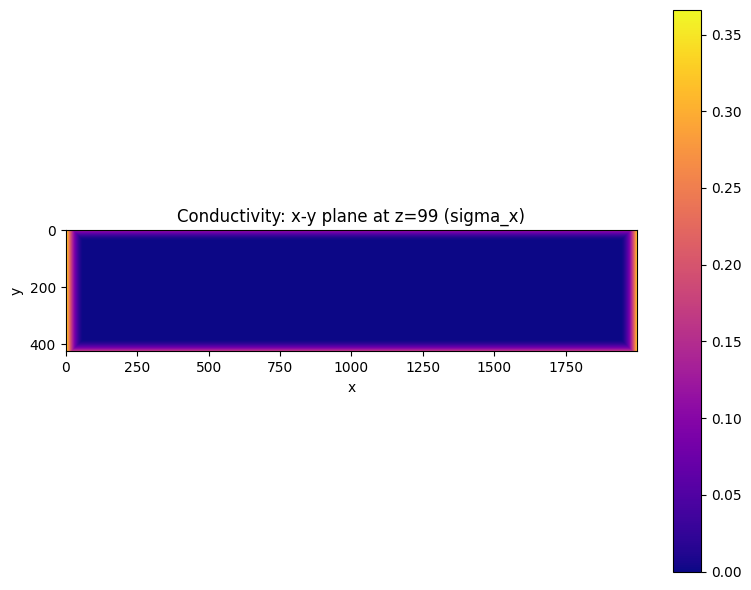

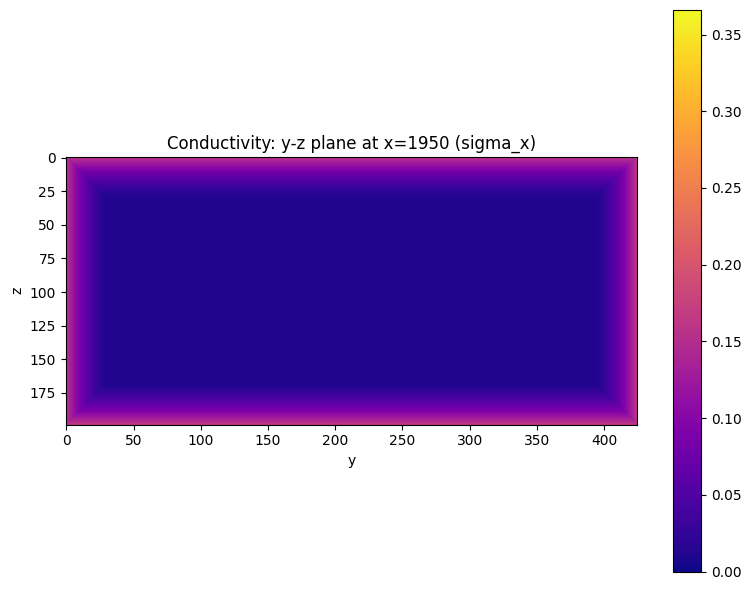

In [9]:
#add adiabatic absorbers to structure conductivity
user_structure.conductivity = jnp.zeros_like(user_structure.conductivity)
user_structure.conductivity = user_structure.conductivity + absorber

user_structure.view(
    show_permittivity=False,
    show_conductivity=True,
    axis="z",
    position=slab_thickness_cells + coupler_thickness_cells // 2,
)

user_structure.view(
    show_permittivity=False,
    show_conductivity=True,
    axis="x",
    position=user_structure.permittivity.shape[1] - 50,
)

X-propagating mode in Y region: [212:425]

=== Mode 0 Solver ===
Propagation axis: x
Source position: x=65
Source plane shape: (3, 1, 213, 199)
Mode beta: [0.19685328]
Mode error: [0.0041671]
Mode field shape: (3, 213, 199)


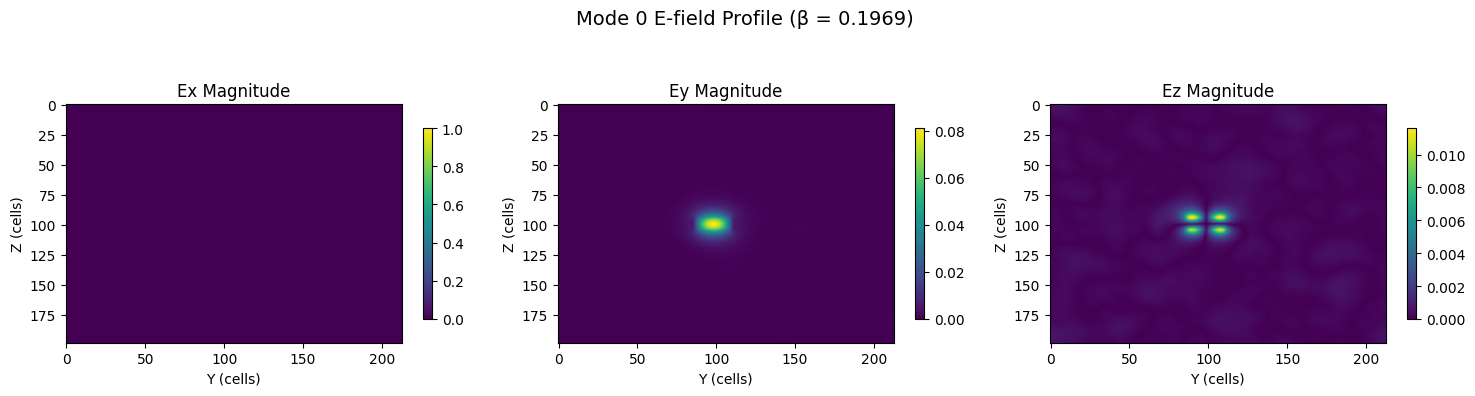

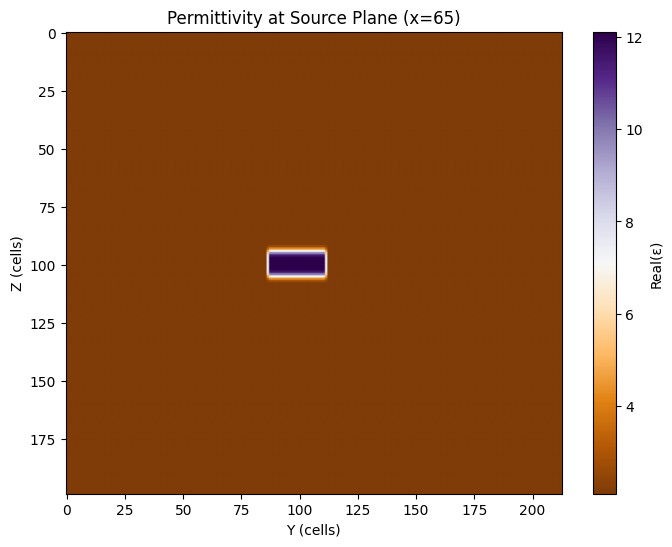

Padded mode field from Y size 213 to full Y size 425
Source field shape: (1, 6, 1, 425, 199)
Source offset: (65, 0, 0)


In [10]:
#@title Create Mode Source

# Simulation parameters
wl = 1.55   # wavelength in microns

wl_cells = 1.55/resolution

freq_band = (2 * jnp.pi / wl_cells, 2 * jnp.pi / wl_cells, 1)  # (2*jnp.pi / wl_cells_max, 2*jnp.pi / wl_cells_min, num_frequencies)
mode_num = 0
num_steps = 10000
check_every_n = 1000
source_ramp_periods = 5.0
field_to_plot = 'all'
source_pos_x = abs_shape[0] + 5   # 5 voxels right of left absorber

# Create mode source with visualization
source_field, source_offset, mode_info = hwc.create_mode_source(
    structure=user_structure,
    freq_band=freq_band,
    mode_num=mode_num,
    propagation_axis="x",
    source_position=source_pos_x,
    perpendicular_bounds=(Ly//2, Ly),  # Limit to bottom half to only solve for the mode of the bottom waveguide
    visualize=True,
    visualize_permittivity=True,
    debug=True
)

In [11]:
#@title Set up Monitors
monitors = hwc.MonitorSet()

monitors.add_monitors_at_position(
    structure=user_structure,
    axis="x",
    position=abs_shape[0] + 10,   # 10 voxels right of left absorber
    label="Input"
)

monitors.remove(
    'Input_top'
)

monitors.add_monitors_at_position(
    structure=user_structure,
    axis="x",
    position=Lx - (abs_shape[0] + 10), # 10 voxels left of right absorber
    label="Output"
)

monitors.list_monitors()

['Input_bottom', 'Output_top', 'Output_bottom']

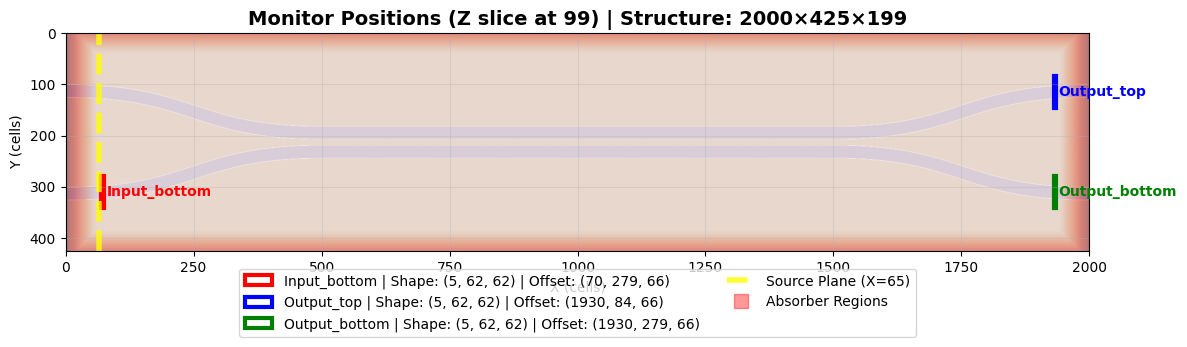

In [12]:
monitors.view(
    structure=user_structure,
    axis="z",
    position=Lz//2,
    source_position=source_pos_x,
    absorber_boundary=absorber,
)

### Simulation

In [ ]:
#@title Run FDTD simulation on cloud GPU

# Extract recipes for sending to cloud (structures are too large to send directly)
structure_recipe = user_structure.extract_recipe()
monitors_recipe = monitors.recipe

results = hwc.simulate(
    structure_recipe=structure_recipe,
    source_field=source_field,
    source_offset=source_offset,
    freq_band=freq_band,
    monitors_recipe=monitors_recipe,
    mode_info=mode_info,
    simulation_steps=20000,
    check_every_n=1000,
    source_ramp_periods=5.0,
    add_absorption=True,
    absorption_widths=abs_shape,
    absorption_coeff=abs_coeff,
    api_key=api_key,
    gpu_type="B200"   # Options: "B200", "H200", "H100", "A100-80GB", "A100-40GB", "L40S", "L4", "A10G", "T4"
)

print(f"GPU time: {results['sim_time']:.2f}s")   # Billed GPU time (data transfer/GPU initialization excluded)
print(f"Performance: {results['performance']:.2e} grid-points x steps/s")   # Speed in Voxels/s

In [ ]:
hwc.quick_view_monitors(results, component="all")

In [ ]:
#@title Result Analysis

# Self-contained S_from_slice function
def S_from_slice(field_slice):
    """Calculate Poynting vector from field slice."""
    E = field_slice[:, :3, :, :]  # Ex, Ey, Ez
    H = field_slice[:, 3:, :, :]   # Hx, Hy, Hz

    # Poynting vector S = E x H*
    S = jnp.zeros_like(E, dtype=jnp.float32)
    S = S.at[:, 0, :, :].set(jnp.real(E[:, 1, :, :] * jnp.conj(H[:, 2, :, :]) - E[:, 2, :, :] * jnp.conj(H[:, 1, :, :])))  # Sx
    S = S.at[:, 1, :, :].set(jnp.real(E[:, 2, :, :] * jnp.conj(H[:, 0, :, :]) - E[:, 0, :, :] * jnp.conj(H[:, 2, :, :])))  # Sy
    S = S.at[:, 2, :, :].set(jnp.real(E[:, 0, :, :] * jnp.conj(H[:, 1, :, :]) - E[:, 1, :, :] * jnp.conj(H[:, 0, :, :])))  # Sz

    return S * 0.5  # Time-averaged Poynting vector

# Main analysis
monitor_data = results['monitor_data']

# Get field data using monitor names directly
input_fields = monitor_data['Input_bottom']
output_bottom_fields = monitor_data['Output_bottom']
output_top_fields = monitor_data['Output_top']

print(f"Field shapes: {input_fields.shape}")

# Average across X thickness (monitor thickness)
input_plane = jnp.mean(input_fields, axis=2)
output_bottom_plane = jnp.mean(output_bottom_fields, axis=2)
output_top_plane = jnp.mean(output_top_fields, axis=2)

# Calculate Poynting vectors
S_input = S_from_slice(input_plane)
S_output_bottom = S_from_slice(output_bottom_plane)
S_output_top = S_from_slice(output_top_plane)

# Calculate power (X-component, take absolute value to handle direction)
power_in = jnp.abs(jnp.sum(S_input[:, 0, :, :], axis=(1, 2)))
power_out_bottom = jnp.abs(jnp.sum(S_output_bottom[:, 0, :, :], axis=(1, 2)))
power_out_top = jnp.abs(jnp.sum(S_output_top[:, 0, :, :], axis=(1, 2)))
power_out_total = power_out_bottom + power_out_top

# Metrics
total_transmission = power_out_total / power_in
split_bottom = power_out_bottom / power_out_total
split_top = power_out_top / power_out_total

# Wavelengths
freq_min, freq_max, num_freqs = freq_band
frequencies = jnp.linspace(freq_min, freq_max, num_freqs)
wavelengths = 2 * jnp.pi / frequencies

# Print results
print("\nPower Analysis:")
for i in range(num_freqs):
    print(f"lambda = {wavelengths[i]:.3f}:")
    print(f"  Input: {power_in[i]:.4e}")
    print(f"  Output Bottom: {power_out_bottom[i]:.4e}")
    print(f"  Output Top: {power_out_top[i]:.4e}")
    print(f"  Output Total: {power_out_total[i]:.4e}")
    print(f"  Transmission: {total_transmission[i]:.1%}")
    print(f"  Split: {split_bottom[i]:.1%} bottom / {split_top[i]:.1%} top")

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Power levels
ax1.semilogy(wavelengths, power_in, 'b-', linewidth=2, label='Input')
ax1.semilogy(wavelengths, power_out_total, 'k--', linewidth=2, label='Total Output')
ax1.semilogy(wavelengths, power_out_bottom, 'r-o', label='Bottom')
ax1.semilogy(wavelengths, power_out_top, 'g-s', label='Top')
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Power (a.u.)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Power Flow')

# Total transmission
ax2.plot(wavelengths, total_transmission * 100, 'k-o', linewidth=2)
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=90, color='gray', linestyle='--', alpha=0.3)
ax2.set_xlabel('Wavelength (um)')
ax2.set_ylabel('Transmission (%)')
ax2.set_ylim(0, 110)
ax2.grid(True, alpha=0.3)
ax2.set_title('Total Transmission')

# Splitting ratio
ax3.plot(wavelengths, split_bottom * 100, 'r-o', linewidth=2, label='Bottom')
ax3.plot(wavelengths, split_top * 100, 'g-s', linewidth=2, label='Top')
ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax3.set_xlabel('Wavelength (um)')
ax3.set_ylabel('Power Split (%)')
ax3.set_ylim(0, 100)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_title('Output Power Distribution')

plt.tight_layout()
plt.show()

print(f"\nAverage Transmission: {jnp.mean(total_transmission):.1%}")
print(f"Average Split: {jnp.mean(split_bottom):.1%} bottom / {jnp.mean(split_top):.1%} top")

In [ ]:
#@title Export as GDS file

hwc.generate_gds_from_density(
    density_array=d_coupler,
    output_filename="coupler.gds",
    resolution=resolution
)

In [ ]:
hwc.view_gds(
    gds_filepath='coupler.gds',
    density_array=d_coupler
)